In [1]:
import os
import yaml

def get_all_experiments(dir):
    experiments = []
    for subdir, dirs, files in os.walk(f'../../results/{dir}'):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".yaml"):
                with open(filepath) as f:
                    data = yaml.load(f, Loader=yaml.FullLoader)
                experiments.append(data)
    return experiments

def filter_by_exp_tag(experiments, exp_tag):
    filtered = []
    for experiment in experiments:
        if experiment['exp_tag'] == exp_tag:
                    filtered.append(experiment)
    return filtered

In [2]:
exp_tag_to_exp_variable = {
    'death_delay_mean' : 'deaths_delay_mean_shift'
}

def get_exp_variables(experiments):
    exp_vars_name = exp_tag_to_exp_variable[experiments[0]['exp_tag']]

    exp_vars = []
    for i, experiment in enumerate(experiments):
        exp_vars.append(experiment['exp_config'][exp_vars_name])
    return exp_vars_name, exp_vars

In [3]:
res_dir = 'rc_3a_cdef_drop_outdoors'
all_experiments = get_all_experiments(res_dir)

In [8]:
death_delay_mean_experiments = filter_by_exp_tag(all_experiments, 'death_delay_mean')
death_delay_name, death_delays = get_exp_variables(death_delay_mean_experiments)


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_intervention_effectiveness(
    posterior_samples,
    cm_names=None,
    intervention_varname="alpha_i",
    xlim="auto",
    newfig=True,
):
    if newfig:
        plt.figure(figsize=(4, 4), dpi=300)

    if isinstance(posterior_samples, dict):
        per_red = 100 * (1 - np.exp(-np.array(posterior_samples[intervention_varname])))
    else:
        per_red = 100 * (1 - np.exp(-np.array(posterior_samples)))

    median_alpha = np.median(per_red, axis=0)

    nS, nCMs = per_red.shape
    print(nS, nCMs)

    li, lq, uq, ui = np.percentile(per_red, [2.5, 25, 75, 97.5], axis=0)
    print(li, lq, uq, ui)
    for n in range(nCMs):
        plt.plot([li[n], ui[n]], [-n, -n], color="k", alpha=0.1)
        plt.plot([lq[n], uq[n]], [-n, -n], color="k", alpha=0.5)

    plt.plot([0, 0], [0.5, -nCMs - 2], "k--", linewidth=0.5)

    if cm_names is None:
        cm_names = [f"NPI {i + 1}" for i in range(nCMs)]

    assert len(cm_names) == nCMs

    plt.yticks(-np.arange(len(median_alpha)), cm_names)
    plt.scatter(median_alpha, -np.arange(len(median_alpha)), marker="|", color="k")
    plt.xlabel("Percentage reduction in $R_t$")
    plt.ylim([-nCMs + 0.5, 0.5])

    if xlim == "auto":
        lower_xlim, upper_xlim = plt.xlim()
        print(lower_xlim, upper_xlim)
        lower_xlim = np.floor(lower_xlim / 25.0) * 25
        upper_xlim = np.ceil(upper_xlim / 25.0) * 25
        plt.xlim([lower_xlim, upper_xlim])
    else:
        plt.xlim(xlim)
        lower_xlim, upper_xlim = plt.xlim()

    for i in range(0, nCMs, 2):
        plt.fill_between(
            [lower_xlim, upper_xlim],
            [-i + 0.5, -i + 0.5],
            [-i - 0.5, -i - 0.5],
            color="k",
            alpha=0.1,
            linewidth=0,
        )

    plt.title("NPI Effectiveness")

2000 20
[  3.3970821    7.22100462  -0.60917673   1.50874528 -17.04251177
  -1.40014711  -4.59333056   4.61701703   1.58738643   4.10013608
  -7.19643239  -1.6689372   -2.38556401  -1.67970335  -3.30733427
  -1.45667318  -9.08085491  -1.36197866  -7.21751078   9.82982138] [  6.55695024  10.23106131   2.55843658   5.95716471 -12.11089011
   0.62432276  -1.46672021   7.08628191   5.62444704  10.33031884
  -2.14496115   0.81223876   0.14442109   1.4835587    0.13697272
   1.82169898  -4.91082952   1.1020628   -2.05470813  13.3517264 ] [ 9.90823559 13.20982817  6.49767842 10.98396534 -7.39178508  3.54172268
  0.77617744  9.5733818   9.92295089 16.73086387  0.90952532  4.34014347
  3.18611134  6.28708395  4.78770372  6.67654507 -0.88723064  4.93878729
  0.86152237 16.68430025] [12.9284724  15.98965941 10.04418745 15.54074279 -2.87691743  7.10229335
  3.23452427 11.67231604 13.55176008 22.66872955  4.61243832  8.35896164
  7.06376011 10.93473535  9.95791134 11.29388573  1.38574559  8.9959120

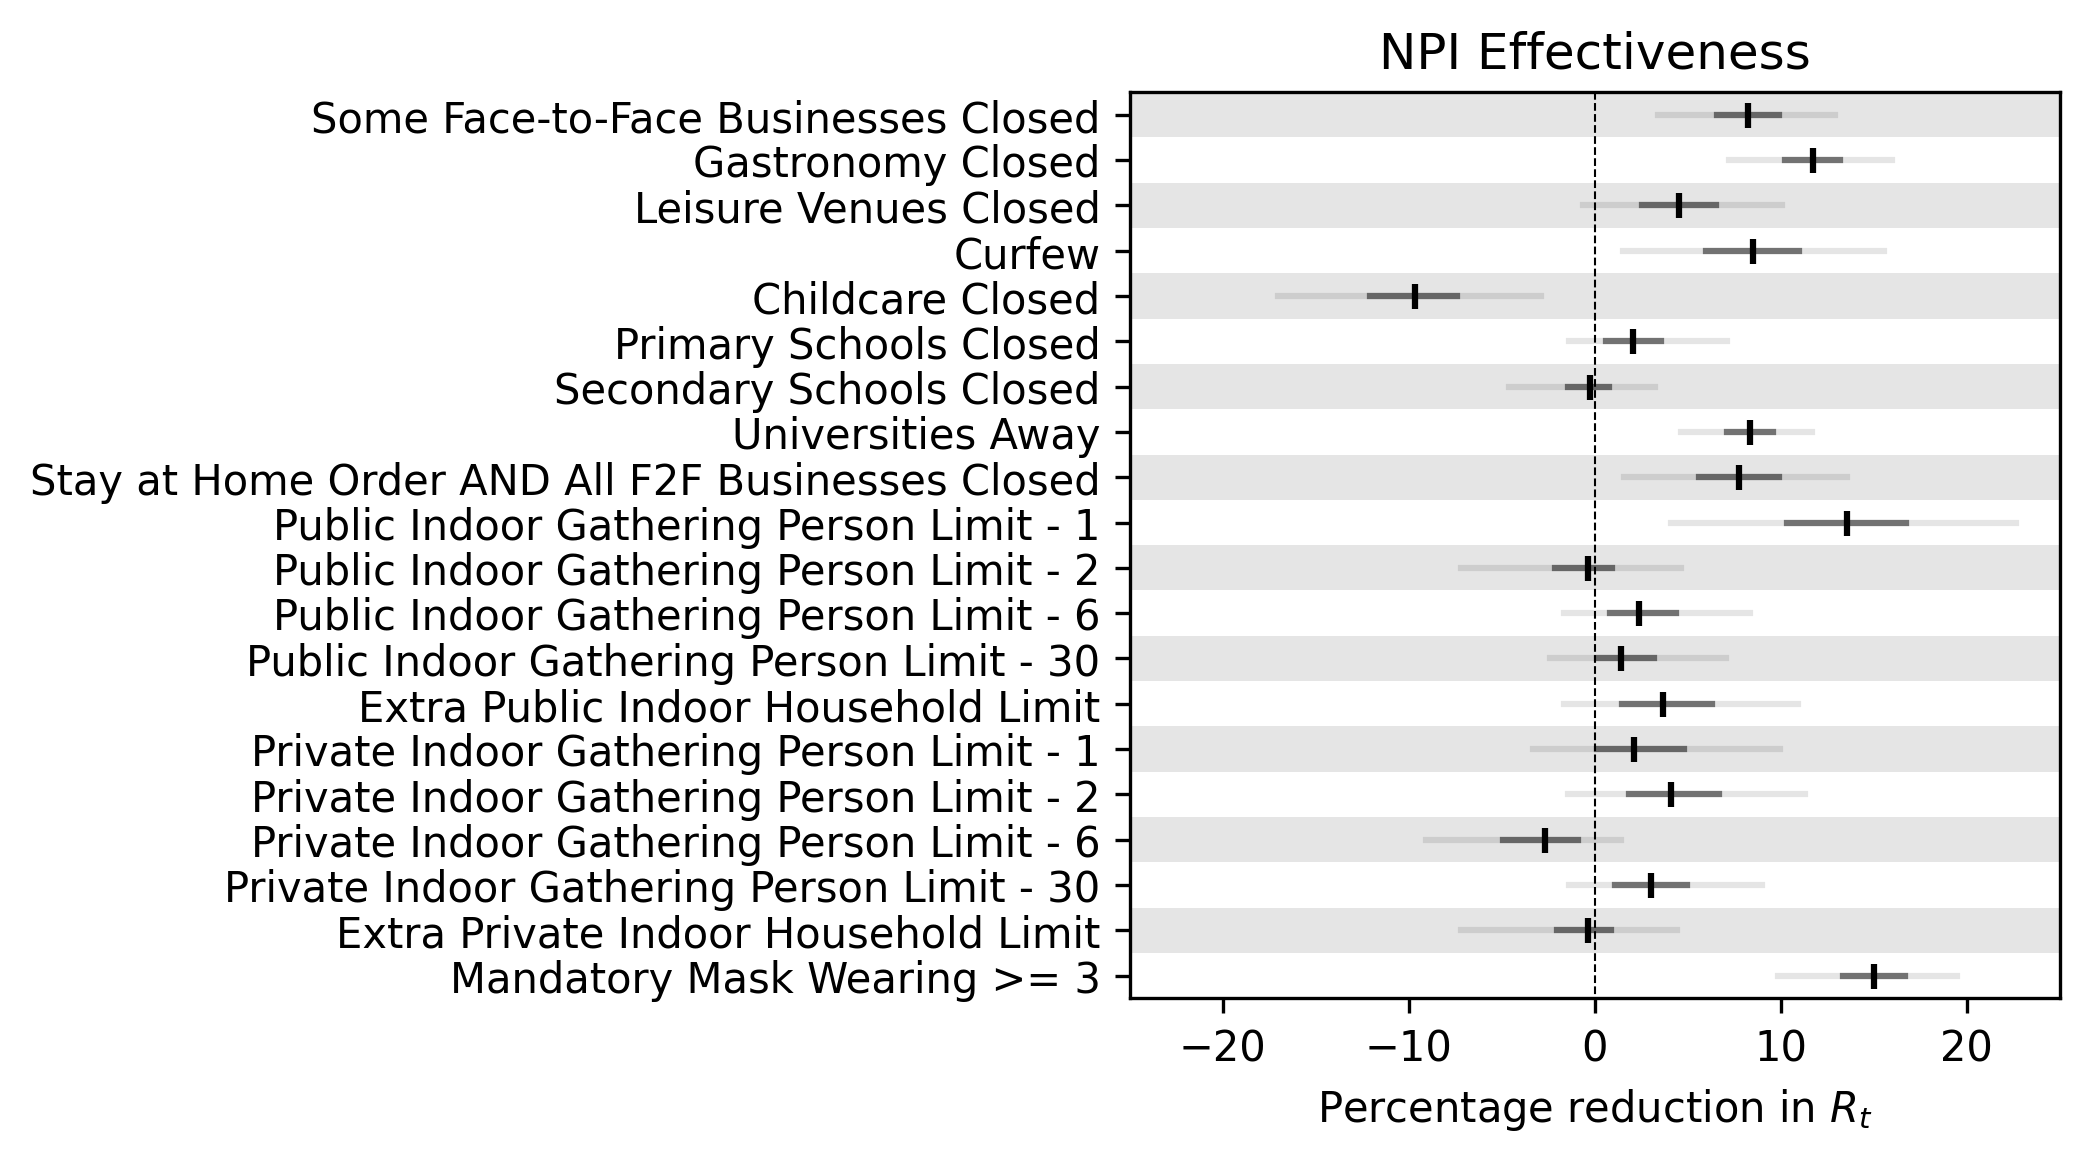

In [39]:
plot_intervention_effectiveness(death_delay_mean_experiments[0],
                                cm_names=death_delay_mean_experiments[0]['cm_names'],
                                )

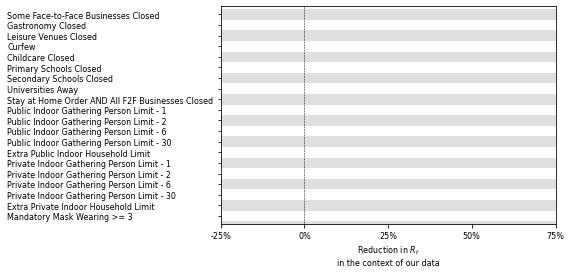

In [16]:
def produce_ranges(per_red, intervention_varname='alpha_i'):

    median_alpha = np.median(per_red, axis=0)
    mean_alphi = np.mean(per_red, axis=0)

    li, lq, uq, ui = np.percentile(per_red, [2.5, 25, 75, 97.5], axis=0)

    return mean_alphi, median_alpha, li, ui, lq, uq

def add_trace_to_plot(posterior_samples, y_off, col, label, alpha, width, size=8, zeros=None, derived_features=None, intervention_varname='alpha_i'):
    if derived_features is None:
        derived_features = posterior_samples['cm_names']

    if isinstance(posterior_samples, dict):
        per_red = 100 * (1 - np.exp(-np.array(posterior_samples[intervention_varname])))
    else:
        per_red = 100 * (1 - np.exp(-np.array(posterior_samples)))

    nS, _ = per_red.shape
    nF = len(derived_features)
    # derived_samples = np.zeros((nS, nF))
    #
    # for f_i, (f, prodrows) in enumerate(derived_features):
    #     samples = np.ones(nS)
    #     for r in prodrows:
    #         samples = samples * per_red[:, r]
    #     derived_samples[:, f_i] = samples
    #
    # res = derived_samples
    # res = 100*(1-res)

    # if zeros is not None:
    #     for z in zeros:
    #         if z < nF:
    #             res[:, z] = 1e5

    y_vals = -1 * np.arange(nF)
    plt.plot([100], [100], color=col, linewidth=1, alpha=alpha, label=label)
    mn, med, li, ui, lq, uq = produce_ranges(per_red)
    plt.scatter(med, y_vals+y_off, marker="|", color=col, s=size, alpha=alpha)
    for cm in range(nF):
        plt.plot([li[cm], ui[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.25, linewidth=width)
        plt.plot([lq[cm], uq[cm]], [y_vals[cm]+y_off, y_vals[cm]+y_off], color=col, alpha=alpha*0.75, linewidth=width)

def setup_large_plot(posterior_samples, y_ticks = True, xlabel=True, derived_features=None):
    if derived_features is None:
        derived_features = posterior_samples['cm_names']

    nF = len(derived_features)
    ax = plt.gca()
    x_min = -25
    x_max = 75
    plt.plot([0, 0], [1, -(nF+2)], "--k", linewidth=0.5)

    xrange = np.array([x_min, x_max])
    for height in range(0, nF+2, 2):
        plt.fill_between(xrange, -(height-0.5), -(height+0.5), color="silver", alpha=0.5, linewidth=0)
    xtick_vals = [-25, 0, 25, 50, 75, 100]
    xtick_str = [f"{x:.0f}%" for x in xtick_vals]
    if y_ticks:
        plt.yticks(-np.arange(nF), [f"{f}" for f in derived_features], fontsize=8, ha="left")
        yax = ax.get_yaxis()
        yax.set_tick_params(pad=210)

    else:
        plt.yticks([])
    x_r = np.abs(x_min - x_max)
    plt.xticks(xtick_vals, xtick_str, fontsize=8)
    plt.xlim([x_min, x_max])
    plt.ylim([-(nF - 0.25), 0.75])

    if xlabel:
        plt.xlabel("Reduction in $R_t$\nin the context of our data", fontsize=8)

In [26]:
def sort_experiments(exp_vars, experiments):
    try:
        new_dict = dict(sorted(dict(zip(exp_vars, experiments)).items()))
        return list(new_dict.keys()), list(new_dict.values())
    except:
        return

death_delays, death_delay_mean_experiments = sort_experiments(death_delays, death_delay_mean_experiments)


Text(0.5, 1.0, 'deaths_delay_mean_shift')

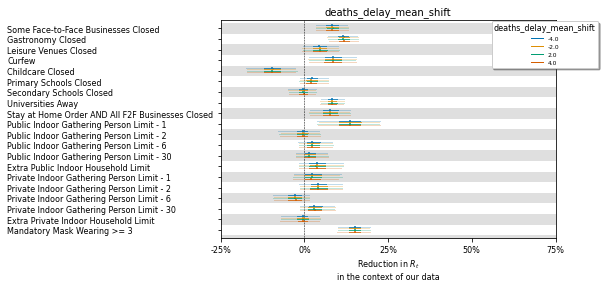

In [27]:
setup_large_plot(death_delay_mean_experiments[0])

colors = [*sns.color_palette("colorblind"), *sns.color_palette("dark")]

death_delay_name, death_delays = get_exp_variables(death_delay_mean_experiments)

y_off = -np.linspace(-0.3, 0.3, len(death_delay_mean_experiments)+1)
width = 1
for i, trace in enumerate(death_delay_mean_experiments):
    add_trace_to_plot(trace, y_off[i], colors[i], death_delays[i], 1, width)
# add_trace_to_plot(default_res, y_off[-1], 'k', "Default", 1, width)

plt.legend(shadow=True, fancybox=True, loc="upper left", bbox_to_anchor=(0.8, 1.01), fontsize=6, title=f'{death_delay_name}', title_fontsize=8)
plt.title(f"{death_delay_name}", fontsize="10")






In [ ]:
def plot_intervention_correlation(
    posterior_samples,
    cm_names=None,
    intervention_varname="alpha_i",
    newfig=True,
):
    if newfig:
        plt.figure(figsize=(3, 4.5), dpi=300)

    if isinstance(posterior_samples, dict):
        cormat = np.corrcoef(posterior_samples[intervention_varname].T)
    else:
        cormat = np.corrcoef(posterior_samples.T)

    nCMs, _ = cormat.shape
    if cm_names is None:
        cm_names = [f"NPI {i + 1}" for i in range(nCMs)]

    assert len(cm_names) == nCMs

    plt.imshow(cormat, vmin=-1, vmax=1, cmap="PuOr")
    plt.colorbar()
    plt.xticks(np.arange(nCMs), cm_names, rotation=90, fontsize=4)
    plt.yticks(np.arange(nCMs), cm_names, fontsize=4)
    plt.title(f"most correlation\n: {np.min(cormat):-.2f}")

def plot_intervention_sd(
    posterior_samples,
    cm_names=None,
    sd_varname="sigma_i",
    xlim=None,
):
    if isinstance(posterior_samples, dict):
        sigma = posterior_samples[sd_varname]
    else:
        sigma = posterior_samples

    if xlim is None:
        xlim = [0, 1]

    nS, _, nCMs = sigma.shape
    sigma = sigma.reshape((nS, nCMs))

    median_alpha = np.median(sigma, axis=0)

    for i in range(0, nCMs, 2):
        plt.fill_between(
            [-100, 100],
            [-i + 0.5, -i + 0.5],
            [-i - 0.5, -i - 0.5],
            color="k",
            alpha=0.1,
            linewidth=0,
        )

    li, lq, uq, ui = np.percentile(sigma, [2.5, 25, 75, 97.5], axis=0)

    for n in range(nCMs):
        plt.plot([li[n], ui[n]], [-n, -n], color="k", alpha=0.1)
        plt.plot([lq[n], uq[n]], [-n, -n], color="k", alpha=0.5)

    plt.plot([0, 0], [0.5, -nCMs - 2], "k--", linewidth=0.5)

    if cm_names is None:
        cm_names = [f"NPI {i + 1}" for i in range(nCMs)]

    assert len(cm_names) == nCMs

    plt.yticks(-np.arange(len(median_alpha)), cm_names)
    plt.scatter(median_alpha, -np.arange(len(median_alpha)), marker="|", color="k")
    plt.xlabel("Percentage reduction in $R_t$")
    plt.ylim([-nCMs + 0.5, 0.5])

    if xlim == "auto":
        lower_xlim, upper_xlim = plt.xlim()
        lower_xlim = np.floor(lower_xlim / 25.0) * 1
        upper_xlim = np.ceil(upper_xlim / 25.0) * 1
        plt.xlim([lower_xlim, upper_xlim])
    else:
        plt.xlim(xlim)

    plt.title("NPI Effectiveness Variability")



In [ ]:
grouped_npi_base = {
    "Some Face-to-Face Businesses Closed": {
        "npis": ["Some Face-to-Face Businesses Closed"],
        "type": "include"},
    "Gastronomy Closed": {
        "npis": ["Gastronomy Closed"],
        "type": "include"},
    "Leisure Venues Closed": {
        "npis": ["Leisure Venues Closed"],
        "type": "include"},
    "All Face-to-Face Businesses Closed + Stay at Home Order": {
        "npis": ["All Face-to-Face Businesses Closed", "Leisure Venues Closed", "Gastronomy Closed", "Some Face-to-Face Businesses Closed", "Stay at Home Order"],
        "type": "include"},
    "Curfew": {
        "npis": ["Curfew"],
        "type": "include"},
    "Childcare Closed": {
        "npis": ["Childcare Closed"],
        "type": "include"},
    "Schools Closed": {
        "npis": ["Primary Schools Closed", "Secondary Schools Closed"],
        "type": "include"},
    "All Education Closed": {
        "npis": ["Primary Schools Closed", "Secondary Schools Closed", "Universities Away", "Childcare Closed"],
        "type": "include"},
    "Universities Away": {
        "npis": ["Universities Away"],
        "type": "include"},
    "Mandatory Mask Wearing >= 3": {
        "npis": ['Mandatory Mask Wearing >= 3'],
        "type": "include"}
}
def combine_npi_samples(grouped_npis, alpha_i_samples, npi_names):
    nS, nCMs_orig = alpha_i_samples.shape
    CMs_new = list(grouped_npis.keys())
    CMs_new_include = np.ones(len(CMs_new), dtype=np.bool)
    nCMs_new = len(CMs_new)

    new_samples = np.zeros((nS, nCMs_new))
    for cm_i_new, (gnpi, sub_npilist_dict) in enumerate(grouped_npis.items()):
        sub_npilist = sub_npilist_dict["npis"]
        add_type = sub_npilist_dict["type"]

        for cm in sub_npilist:
            if cm in npi_names:
                new_samples[:, cm_i_new] += alpha_i_samples[:, npi_names.index(cm)]
            elif add_type == "exclude":
                CMs_new_include[cm_i_new] = False

    CMs_new = np.array(CMs_new)[CMs_new_include].tolist()
    new_samples = new_samples[:, CMs_new_include]

    return new_samples, CMs_new

In [ ]:
# config = load_model_config(args.model_config)
# pprint_mb_dict(config)

from epimodel import preprocess_data
all_merged = preprocess_data('../../data/all_merged_data.csv')
all_merged.featurize(drop_npi_filter = res.featurize_kwargs['drop_npi_filter'])
npi_names = all_merged.CMs

In [ ]:
samples, newCMs = combine_npi_samples(grouped_npi_base, pd.DataFrame(res.alpha_i).T, npi_names)